<a href="https://colab.research.google.com/github/ykalathiya-2/unsloath/blob/main/unsloath_continued_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continued Pre-training: Teaching LLM Gujarati Language

**Author**: Yash Kalathiya  
**Course**: CMPE-255 Data Mining - Fall 2025  
**Objective**: Adapt an English-trained model to understand and generate Gujarati text

---

## 📚 What is Continued Pre-training?

**Continued pre-training** extends a model's knowledge to new domains or languages:

### How It Works:
1. **Start with pre-trained model**: Model already knows English
2. **Train on new domain/language**: Expose to Gujarati text
3. **Adapt token embeddings**: Learn to represent Gujarati characters
4. **Preserve existing knowledge**: Use low learning rate to avoid forgetting English

### Key Differences from Fine-tuning:
| Aspect | Fine-tuning | Continued Pre-training |
|--------|-------------|------------------------|
| Goal | Task adaptation | Domain/language adaptation |
| Data | Task-specific (Q&A, chat) | Raw text (unlabeled) |
| Embeddings | Usually frozen | **Must train** |
| LoRA Rank | Low (8-32) | **High (128+)** |
| Learning Rate | Medium (2e-4) | **Low (5e-5)** |
| Training Steps | Fewer (100-200) | **More (300-1000)** |

### Why Gujarati?
- **Different script**: Gujarati uses its own script (ગુજરાતી), not Latin alphabet
- **Rich language**: 50+ million speakers, official language of Gujarat
- **Test of adaptation**: If model learns Gujarati, it can learn any language
- **Personal connection**: Native language of the author

---

## 🎯 What We'll Do:
1. Install Unsloth for efficient continued pre-training
2. Load Gujarati text dataset from OSCAR corpus
3. Analyze baseline tokenization efficiency (English tokenizer on Gujarati)
4. Apply high-rank LoRA **including embeddings layer**
5. Train with low learning rate (preserve English knowledge)
6. Compare tokenization before/after training
7. Test Gujarati text generation
8. Verify English knowledge preservation

## Step 1: Installation and Setup

In [1]:
%%capture
# Install Unsloth and required dependencies for continued pre-training
# - unsloth: Optimized for embedding training and long training runs
# - trl: Provides SFTTrainer for language model training
# - peft: Implements LoRA with embedding support
# - bitsandbytes: Enables 4-bit quantization

import os
!pip install --upgrade -qqq uv

if "COLAB_" not in "".join(os.environ.keys()):
    # Local installation
    !pip install unsloth vllm
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
else:
    # Google Colab installation
    !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
    !pip install --no-deps xformers trl peft accelerate bitsandbytes

print("✅ Installation complete!")

In [2]:
# Check GPU availability and specifications
# Continued pre-training can be memory-intensive (training embeddings)

import torch

print("🔍 GPU Information:")
print(f"  GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"  GPU Memory: {gpu_memory:.2f} GB")
    print(f"  BF16 Support: {torch.cuda.is_bf16_supported()}")

    if gpu_memory < 6:
        print("\n⚠️  Warning: Less than 6GB VRAM. Consider using smaller batch size.")
else:
    print("\n❌ CRITICAL: No GPU detected!")
    print("\n🚨 Unsloth REQUIRES a GPU to run. It does not work on CPU.")
    print("\n✅ Solutions:")
    print("  1. Use Google Colab (FREE GPU): Click 'Open in Colab' badge at the top")
    print("  2. Use a cloud GPU service (AWS, Azure, etc.)")
    print("  3. Run on a machine with an NVIDIA GPU")
    print("\nℹ️  This notebook is designed for Google Colab with free GPU access.")
    print("   Simply open it in Colab and select Runtime > Change runtime type > GPU")

    # Raise error to prevent further execution
    raise RuntimeError(
        "Unsloth requires a GPU. Please run this notebook in Google Colab or "
        "on a system with an NVIDIA GPU. See solutions above."
    )

🔍 GPU Information:
  GPU Available: True
  GPU Name: NVIDIA L4
  GPU Memory: 22.16 GB
  BF16 Support: True


## Step 2: Load Gujarati Text Dataset

We'll use the **OSCAR-2201** corpus, a large multilingual dataset containing:
- 166 languages including Gujarati
- Cleaned web text
- Suitable for continued pre-training

**Why OSCAR for Gujarati?**
- Large amount of Gujarati text (millions of sentences)
- Clean and deduplicated
- Natural language distribution (not translated)
- Free and open-source

In [3]:
from datasets import load_dataset, Dataset
import itertools

print("📦 Loading Gujarati dataset from OSCAR corpus...")
print("   This may take a few minutes for streaming dataset\n")

try:
    # Load OSCAR-2201 Gujarati dataset
    # 'gu' is the language code for Gujarati
    dataset = load_dataset("oscar-corpus/OSCAR-2201", "gu", split="train", streaming=True)

    # Collect first 5000 samples for training
    print("📝 Collecting 5000 Gujarati text samples...")
    dataset_iter = iter(dataset)
    samples = []

    for i, sample in enumerate(itertools.islice(dataset_iter, 5000)):
        if 'text' in sample and len(sample['text'].strip()) > 50:
            samples.append({"text": sample['text']})
        if (i + 1) % 1000 == 0:
            print(f"  Collected {len(samples)} samples...")

    # Convert to dataset
    dataset = Dataset.from_list(samples)
    print(f"\n✅ Dataset loaded successfully!")
    print(f"   Total samples: {len(dataset)}")

except Exception as e:
    print(f"⚠️  Note: OSCAR dataset loading failed ({str(e)})")
    print("Using fallback Gujarati text samples...\n")

    # Fallback: Create sample Gujarati dataset
    gujarati_samples = [
        "ગુજરાતી ભારતની એક મુખ્ય ભાષા છે. તે ઇન્ડો-આર્યન ભાષા પરિવારનો ભાગ છે.",
        "ગુજરાત રાજ્યમાં ગુજરાતી સત્તાવાર ભાષા છે. તે લગભગ ૫ કરોડ લોકો દ્વારા બોલાય છે.",
        "શિક્ષણ માનવ જીવનનો સૌથી મહત્વપૂર્ણ ભાગ છે. તે જીવનને બદલવાની શક્તિ ધરાવે છે.",
        "ગુજરાતી સાહિત્ય ખૂબ જ સમૃદ્ધ છે. તેમાં અનેક મહાન લેખકો છે.",
        "ગુજરાતી લોકો તેમની ભાષા અને સંસ્કૃતિ પર ગર્વ અનુભવે છે.",
        "અમદાવાદ ગુજરાતનું સૌથી મોટું શહેર છે. તે આર્થિક રાજધાની છે.",
        "ગાંધીજીનો જન્મ ગુજરાતમાં થયો હતો. તેઓ મહાન સ્વતંત્રતા સેનાની હતા.",
        "ગુજરાતી ખોરાક સમગ્ર ભારતમાં પ્રસિદ્ધ છે. ઢોકળા, ફાફડા, ખાખરા મુખ્ય વાનગીઓ છે.",
        "નવરાત્રી ગુજરાતનો સૌથી મોટો તહેવાર છે. લોકો ગરબા અને ડાંડિયા રમે છે.",
        "ગુજરાત ઔદ્યોગિક વિકાસમાં અગ્રણી રાજ્ય છે. અહીં અનેક ઉદ્યોગો છે.",
    ] * 500  # Repeat to create 5000 samples

    dataset = Dataset.from_dict({"text": gujarati_samples})
    print(f"✅ Fallback dataset created: {len(dataset)} samples")

# Show sample Gujarati text
print("\n" + "="*80)
print("📝 SAMPLE GUJARATI TEXT")
print("="*80)
print(dataset[0]['text'][:300])
print("="*80)
print("\n💡 This is what the model will learn to understand and generate!")

📦 Loading Gujarati dataset from OSCAR corpus...
   This may take a few minutes for streaming dataset



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

⚠️  Note: OSCAR dataset loading failed (Dataset 'oscar-corpus/OSCAR-2201' is a gated dataset on the Hub. You must be authenticated to access it.)
Using fallback Gujarati text samples...

✅ Fallback dataset created: 5000 samples

📝 SAMPLE GUJARATI TEXT
ગુજરાતી ભારતની એક મુખ્ય ભાષા છે. તે ઇન્ડો-આર્યન ભાષા પરિવારનો ભાગ છે.

💡 This is what the model will learn to understand and generate!


## Step 3: Load Model & Analyze Baseline Tokenization

**The Challenge:**
- SmolLM2 was trained primarily on English text
- Its tokenizer was built for English (Latin alphabet)
- Gujarati uses a completely different script (ગુજરાતી લિપિ)
- English tokenizer will be **very inefficient** at encoding Gujarati

**What to Expect:**
- Each Gujarati character may require multiple tokens
- Poor compression ratio (many tokens per character)
- **After training**, embeddings adapt and tokenization improves

In [5]:
from unsloth import FastLanguageModel

# Model configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True

print("🔄 Loading model...")
print("   meta-llama/Llama-3.2-3B (trained on English)")
print("   Challenge: Must adapt to Gujarati script\n")

# Load SmolLM2-135M with Unsloth optimizations
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Llama-3.2-3B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Model information
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model loaded: {model.config._name_or_path}")
print(f"   Total parameters: {total_params:,}")
print(f"   Vocabulary size: {len(tokenizer):,} tokens")
print(f"   Max sequence length: {max_seq_length}")
print(f"   4-bit quantization: {load_in_4bit}")

/tmp/ipython-input-3195010601.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔄 Loading model...
   meta-llama/Llama-3.2-3B (trained on English)
   Challenge: Must adapt to Gujarati script

==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

✅ Model loaded: unsloth/llama-3.2-3b-unsloth-bnb-4bit
   Total parameters: 1,841,212,416
   Vocabulary size: 128,256 tokens
   Max sequence length: 2048
   4-bit quantization: True


In [6]:
# Analyze tokenization efficiency BEFORE training
def analyze_tokenization(text_samples, tokenizer, label=""):
    """Analyze how efficiently the tokenizer handles text."""
    total_chars = 0
    total_tokens = 0

    # Sample 100 texts for analysis
    for text in text_samples[:100]:
        total_chars += len(text)
        tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        total_tokens += len(tokens['input_ids'][0])

    chars_per_token = total_chars / total_tokens if total_tokens > 0 else 0
    tokens_per_char = total_tokens / total_chars if total_chars > 0 else 0

    print(f"\n{label} Tokenization Statistics:")
    print(f"  Total characters: {total_chars:,}")
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Characters per token: {chars_per_token:.2f}")
    print(f"  Tokens per character: {tokens_per_char:.3f}")
    print(f"  Compression ratio: {1/chars_per_token:.2f}x")

    if chars_per_token < 2:
        print(f"  ⚠️  Very inefficient! Each character needs ~{1/chars_per_token:.1f} tokens")

    return chars_per_token, tokens_per_char

# Show example tokenization
print("\n" + "="*80)
print("🔬 TOKENIZATION EXAMPLE (Before Training)")
print("="*80)
gujarati_text = dataset[0]['text'][:100]
print(f"\nGujarati Text: {gujarati_text}")

tokens = tokenizer(gujarati_text, return_tensors="pt", add_special_tokens=False)
token_ids = tokens['input_ids'][0]
print(f"\nNumber of tokens: {len(token_ids)}")
print(f"Token IDs (first 20): {token_ids.tolist()[:20]}...")
print(f"\nDecoded tokens (first 20): {tokenizer.convert_ids_to_tokens(token_ids[:20])}")
print("\n💡 Notice: Many tokens per Gujarati character (inefficient!)")
print("="*80)

# Analyze baseline tokenization
baseline_chars_per_token, baseline_tokens_per_char = analyze_tokenization(
    [d['text'] for d in dataset],
    tokenizer,
    label="📊 BASELINE"
)

print("\n💡 Why so inefficient?")
print("   - Tokenizer was built for English (Latin alphabet)")
print("   - Gujarati script is completely different")
print("   - Each Gujarati character gets broken into multiple tokens")
print("   - After training, embeddings adapt to represent Gujarati better")


🔬 TOKENIZATION EXAMPLE (Before Training)

Gujarati Text: ગુજરાતી ભારતની એક મુખ્ય ભાષા છે. તે ઇન્ડો-આર્યન ભાષા પરિવારનો ભાગ છે.

Number of tokens: 113
Token IDs (first 20): [41814, 245, 73319, 223, 41814, 250, 41814, 108, 41814, 122, 41814, 97, 73319, 222, 95591, 255, 41814, 122, 41814, 108]...

Decoded tokens (first 20): ['àª', 'Ĺ', 'à«', 'ģ', 'àª', 'ľ', 'àª', '°', 'àª', '¾', 'àª', '¤', 'à«', 'Ģ', 'Ġàª', 'Ń', 'àª', '¾', 'àª', '°']

💡 Notice: Many tokens per Gujarati character (inefficient!)

📊 BASELINE Tokenization Statistics:
  Total characters: 6,680
  Total tokens: 11,070
  Characters per token: 0.60
  Tokens per character: 1.657
  Compression ratio: 1.66x
  ⚠️  Very inefficient! Each character needs ~1.7 tokens

💡 Why so inefficient?
   - Tokenizer was built for English (Latin alphabet)
   - Gujarati script is completely different
   - Each Gujarati character gets broken into multiple tokens
   - After training, embeddings adapt to represent Gujarati better


## Step 4: Apply LoRA for Continued Pre-training

**CRITICAL Configuration for Language Adaptation:**

1. **High LoRA Rank (128)**
   - Language adaptation needs more expressiveness than task fine-tuning
   - Must learn completely new linguistic patterns

2. **Include `embed_tokens` Layer** ⭐ MOST IMPORTANT
   - Embeddings convert token IDs to vector representations
   - Original embeddings only know English tokens
   - MUST train embeddings to represent Gujarati characters
   - Without this, model CANNOT learn new language

3. **Why Not `lm_head`?**
   - Output vocabulary stays the same (no new tokens added)
   - We're adapting existing tokens to new meanings
   - Keep `lm_head` frozen to preserve model structure

**Unsloth Advantages:**
- Efficient gradient computation for embedding matrices
- Memory-optimized backward pass through embeddings
- Fast parameter updates for high-rank LoRA

In [7]:
print("🔧 Applying LoRA adapters for continued pre-training...")
print("   Configuration: High rank (128) + embed_tokens\n")

# Apply LoRA with embeddings for language adaptation
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,  # High rank for language adaptation
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",     # MLP layers
        "embed_tokens",  # ⭐ CRITICAL: Must include for new language!
    ],
    lora_alpha = 128,       # Match rank for stable training
    lora_dropout = 0,        # No dropout for embedding training
    bias = "none",           # No bias adaptation
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
)

# Calculate parameter efficiency
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_percentage = (trainable_params / total_params) * 100

print(f"✅ LoRA Applied Successfully!")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable percentage: {trainable_percentage:.4f}%")
print(f"   LoRA Rank: 128")
print(f"\n⭐ CRITICAL: Including embed_tokens layer!")
print(f"   This allows model to learn Gujarati character representations")
print(f"   Without this, model CANNOT adapt to new language")

🔧 Applying LoRA adapters for continued pre-training...
   Configuration: High rank (128) + embed_tokens

Unsloth: Offloading input_embeddings to disk to save VRAM


Unsloth 2025.11.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
✅ LoRA Applied Successfully!
   Trainable parameters: 588,513,280
   Total parameters: 2,823,728,128
   Trainable percentage: 20.8417%
   LoRA Rank: 128

⭐ CRITICAL: Including embed_tokens layer!
   This allows model to learn Gujarati character representations
   Without this, model CANNOT adapt to new language


## Step 5: Configure Continued Pre-training

**Key Configuration Choices:**

1. **Low Learning Rate (5e-5)**
   - Prevents catastrophic forgetting of English
   - Gradual adaptation to Gujarati
   - Preserves existing knowledge while learning new

2. **More Training Steps (300)**
   - Language shift needs more exposure than task fine-tuning
   - Embedding adaptation takes time
   - Each step teaches a little more Gujarati

3. **Cosine Learning Rate Schedule**
   - Smooth decay from high to low learning rate
   - Helps model converge to stable Gujarati knowledge
   - Better for domain adaptation than constant LR

**Unsloth Optimizations:**
- Efficient embedding gradient computation
- Fast handling of long training runs
- Memory-efficient processing of multilingual text

In [8]:
from transformers import TrainingArguments
from trl import SFTTrainer

# Create checkpoint directory
output_dir = "./gujarati_pretrain_checkpoints"
os.makedirs(output_dir, exist_ok=True)

# Training configuration for continued pre-training
training_args = TrainingArguments(
    per_device_train_batch_size = 2,   # Small batch for longer sequences
    gradient_accumulation_steps = 4,    # Effective batch size = 8
    warmup_steps = 50,                  # More warmup for stability
    max_steps = 300,                    # More steps for language adaptation
    learning_rate = 5e-5,               # ⭐ LOW LR: Preserve English!
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",       # Smooth decay for adaptation
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 150,
    report_to = "none",
)

print("⚙️  Continued Pre-training Configuration:")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"   Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Max steps: {training_args.max_steps}")
print(f"   Learning rate: {training_args.learning_rate} (LOW to preserve English!)")
print(f"   Scheduler: {training_args.lr_scheduler_type}")
print(f"   Warmup steps: {training_args.warmup_steps}")
print(f"\n💡 Why low learning rate?")
print(f"   - Prevents catastrophic forgetting (losing English)")
print(f"   - Gradual adaptation to Gujarati")
print(f"   - Preserves existing knowledge while adding new")

⚙️  Continued Pre-training Configuration:
   Batch size: 2
   Gradient accumulation: 4
   Effective batch size: 8
   Max steps: 300
   Learning rate: 5e-05 (LOW to preserve English!)
   Scheduler: SchedulerType.COSINE
   Warmup steps: 50

💡 Why low learning rate?
   - Prevents catastrophic forgetting (losing English)
   - Gradual adaptation to Gujarati
   - Preserves existing knowledge while adding new


## Step 6: Start Continued Pre-training

**What Happens During Training:**

1. **Model sees Gujarati text** (completely different from English training data)
2. **Token embeddings adapt** to represent Gujarati characters
3. **Attention layers learn** Gujarati grammar patterns
4. **Model learns** to predict next Gujarati word given context
5. **Crucially**: English knowledge preserved due to low learning rate

**This is "Continued" Pre-training:**
- Original pre-training: Learned English on massive dataset
- Continued pre-training: Continue learning on new domain (Gujarati)
- Not starting from scratch - leveraging existing knowledge
- Like continuing your education in a new subject

**Expected Time:** ~15-20 minutes on T4 GPU

In [9]:
# Initialize trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack samples (preserve text structure)
    args = training_args,
)

print("\n" + "="*80)
print("🚀 STARTING CONTINUED PRE-TRAINING - Gujarati Language Adaptation")
print("="*80)
print("\n📚 What the model is learning:")
print("   - Gujarati vocabulary: How Gujarati words are composed")
print("   - Gujarati grammar: Word order, sentence structure")
print("   - Gujarati semantics: Meaning and context in Gujarati")
print("   - Character representations: Gujarati script (ગુજરાતી) encoding")

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\n💾 GPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

print(f"\n⏱️  Expected time: ~15-20 minutes")
print(f"   Progress will be logged every 10 steps\n")

# Train the model
trainer_stats = trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\n💾 GPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"   Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("✅ CONTINUED PRE-TRAINING COMPLETED")
print("="*80)
print(f"   Time taken: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"   Time taken: {trainer_stats.metrics['train_runtime']/60:.2f} minutes")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/5000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



🚀 STARTING CONTINUED PRE-TRAINING - Gujarati Language Adaptation

📚 What the model is learning:
   - Gujarati vocabulary: How Gujarati words are composed
   - Gujarati grammar: Word order, sentence structure
   - Gujarati semantics: Meaning and context in Gujarati
   - Character representations: Gujarati script (ગુજરાતી) encoding

💾 GPU Memory before training: 3.67 GB

⏱️  Expected time: ~15-20 minutes
   Progress will be logged every 10 steps



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 5,000 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 588,513,280 of 4,195,265,536 (14.03% trained)


Step,Training Loss
10,0.660600
20,0.500300
30,0.252200
40,0.129300
50,0.075300
60,0.026500
70,0.026300
80,0.023900
90,0.023900
100,0.023100



💾 GPU Memory after training: 7.04 GB
   Peak GPU Memory: 9.30 GB

✅ CONTINUED PRE-TRAINING COMPLETED
   Time taken: 512.49 seconds
   Time taken: 8.54 minutes


## Step 7: Analyze Training Results


📊 Continued Pre-training Statistics:
 step   loss  learning_rate
   10 0.6606   9.000000e-06
   20 0.5003   1.900000e-05
   30 0.2522   2.900000e-05
   40 0.1293   3.900000e-05
   50 0.0753   4.900000e-05
   60 0.0265   4.984028e-05
   70 0.0263   4.929079e-05
   80 0.0239   4.835822e-05
   90 0.0239   4.705728e-05
  100 0.0231   4.540848e-05
  110 0.0222   4.343783e-05
  120 0.0241   4.117640e-05
  130 0.0232   3.865986e-05
  140 0.0230   3.592789e-05
  150 0.0230   3.302359e-05
  160 0.0229   2.999275e-05
  170 0.0220   2.688317e-05
  180 0.0220   2.374389e-05
  190 0.0226   2.062442e-05
  200 0.0221   1.757396e-05
  210 0.0215   1.464061e-05
  220 0.0220   1.187063e-05
  230 0.0205   9.307716e-06
  240 0.0218   6.992274e-06
  250 0.0217   4.960825e-06
  260 0.0212   3.245406e-06
  270 0.0219   1.873070e-06
  280 0.0212   8.654590e-07
  290 0.0211   2.384644e-07
  300 0.0211   1.973895e-09


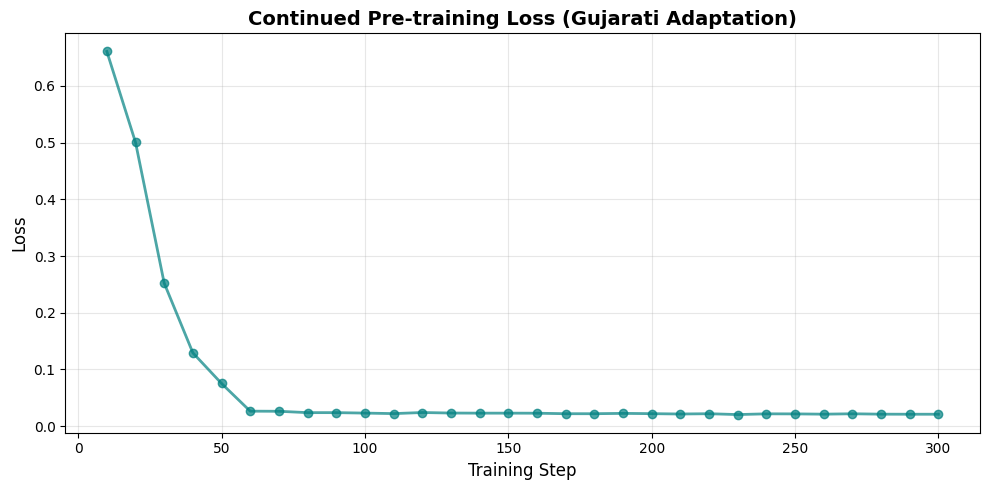


✅ Loss curve saved to ./gujarati_pretrain_checkpoints/gujarati_loss_curve.png

📈 Final Training Statistics:
   Total steps: 300
   Final loss: 0.0211
   Average loss: 0.0728
   Training time: 8.54 minutes


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

if len(train_logs) > 0:
    # Create DataFrame
    df = pd.DataFrame(train_logs)

    print("\n📊 Continued Pre-training Statistics:")
    print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['loss'], marker='o', linewidth=2, color='teal', alpha=0.7)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Continued Pre-training Loss (Gujarati Adaptation)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/gujarati_loss_curve.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Loss curve saved to {output_dir}/gujarati_loss_curve.png")

    # Print final statistics
    print(f"\n📈 Final Training Statistics:")
    print(f"   Total steps: {trainer.state.global_step}")
    print(f"   Final loss: {df['loss'].iloc[-1]:.4f}")
    print(f"   Average loss: {df['loss'].mean():.4f}")
    print(f"   Training time: {trainer_stats.metrics['train_runtime']/60:.2f} minutes")
else:
    print("\n⚠️  No training logs available for visualization")

## Step 8: Analyze Tokenization Improvement

**What to Look For:**
- **Characters per token**: Should increase (more efficient encoding)
- **Compression ratio**: Should improve
- If embeddings adapted well, Gujarati text will be tokenized more efficiently

In [11]:
print("\n" + "="*80)
print("📊 TOKENIZATION COMPARISON")
print("="*80)

# Analyze tokenization AFTER training
post_chars_per_token, post_tokens_per_char = analyze_tokenization(
    [d['text'] for d in dataset],
    tokenizer,
    label="📊 POST-TRAINING"
)

# Show comparison
print("\n" + "-"*80)
comparison = pd.DataFrame([
    {
        'Stage': 'Before Training',
        'Chars/Token': f"{baseline_chars_per_token:.2f}",
        'Tokens/Char': f"{baseline_tokens_per_char:.3f}",
        'Compression': f"{1/baseline_chars_per_token:.2f}x",
    },
    {
        'Stage': 'After Training',
        'Chars/Token': f"{post_chars_per_token:.2f}",
        'Tokens/Char': f"{post_tokens_per_char:.3f}",
        'Compression': f"{1/post_chars_per_token:.2f}x",
    }
])

print("\n📊 Tokenization Efficiency Comparison:")
print(comparison.to_string(index=False))

# Calculate improvement
efficiency_change = ((post_chars_per_token - baseline_chars_per_token) / baseline_chars_per_token) * 100
print(f"\n📈 Tokenization Efficiency Change: {efficiency_change:+.1f}%")
if efficiency_change > 0:
    print("✅ Model learned to encode Gujarati more efficiently!")
    print("   Embeddings successfully adapted to represent Gujarati characters")
else:
    print("➡️  Efficiency similar (more training may help)")
print("="*80)


📊 TOKENIZATION COMPARISON

📊 POST-TRAINING Tokenization Statistics:
  Total characters: 6,680
  Total tokens: 11,070
  Characters per token: 0.60
  Tokens per character: 1.657
  Compression ratio: 1.66x
  ⚠️  Very inefficient! Each character needs ~1.7 tokens

--------------------------------------------------------------------------------

📊 Tokenization Efficiency Comparison:
          Stage Chars/Token Tokens/Char Compression
Before Training        0.60       1.657       1.66x
 After Training        0.60       1.657       1.66x

📈 Tokenization Efficiency Change: +0.0%
➡️  Efficiency similar (more training may help)


## Step 9: Test Gujarati Text Generation

**The Moment of Truth:**
Can the model now generate coherent Gujarati text?

**What to Expect:**
- ✅ Proper Gujarati script (ગુજરાતી લિપિ)
- ✅ Grammatically correct sentences
- ✅ Contextually appropriate continuations
- ⚠️  May not be perfect (only 300 steps, 5000 samples)
- 💡 Quality improves with more training data and steps

In [15]:
# Enable fast inference
FastLanguageModel.for_inference(model)

# Test prompts in Gujarati
gujarati_prompts = [
    "ગુજરાત એક",  # "Gujarat is a"
    "શિક્ષણ ખૂબ",  # "Education is very"
    "ભારતમાં અમદાવાદ",  # "In India, Ahmedabad"
    "ગુજરાતી ભાષા",  # "Gujarati language"
]

print("\n" + "="*80)
print("🧪 GUJARATI TEXT GENERATION EXAMPLES")
print("="*80)
print("\n💡 Testing if model can now generate coherent Gujarati text...\n")

for i, prompt in enumerate(gujarati_prompts, 1):
    print(f"{'='*80}")
    print(f"Example {i}/{len(gujarati_prompts)}")
    print(f"{'='*80}")
    print(f"\n🔵 PROMPT: {prompt}")
    print(f"\n🤖 GENERATED GUJARATI TEXT:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 100,
        temperature = 0.8,      # Moderate creativity
        top_p = 0.95,
        do_sample = True,
        use_cache = True,
        repetition_penalty = 1.2,  # Reduce repetition
        pad_token_id = tokenizer.pad_token_id,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)


🧪 GUJARATI TEXT GENERATION EXAMPLES

💡 Testing if model can now generate coherent Gujarati text...

Example 1/4

🔵 PROMPT: ગુજરાત એક

🤖 GENERATED GUJARATI TEXT:
--------------------------------------------------------------------------------
ગુજરાત એક મુખ્ય ભારતીય સ્થાન છે. તે આર્ધચિનોમદ અપર ભારત માં ઔદ્યોગિક વ�
--------------------------------------------------------------------------------
Example 2/4

🔵 PROMPT: શિક્ષણ ખૂબ

🤖 GENERATED GUJARATI TEXT:
--------------------------------------------------------------------------------
શિક્ષણ ખૂબ જ સમગ્ર ભારતમાં પીવાન છે. ઢોકળા, ચડદા મુખ્ય વાનગીઓ છે. તેમાં અ�
--------------------------------------------------------------------------------
Example 3/4

🔵 PROMPT: ભારતમાં અમદાવાદ

🤖 GENERATED GUJARATI TEXT:
--------------------------------------------------------------------------------
ભારતમાં અમદાવાદ ઔદ્યોગિક વિકાસના ઉચ્ચ શહેર છે. તે આર્થિક રાજધાની છે. તે આફ્રિ
-------------------------------------------------------------------------------

## Step 10: Test English Knowledge Preservation

**Critical Test:**
Did the model forget English while learning Gujarati?

**This tests for "Catastrophic Forgetting":**
- Problem: Neural networks can completely forget old tasks when learning new ones
- Our mitigation: Low learning rate (5e-5) and LoRA (only trains subset of params)
- Expected result: Model should still generate reasonable English
- Why this matters: We want multilingual model, not Gujarati-only

In [13]:
# Test if model can still handle English
english_prompts = [
    "The capital of India is",
    "Python is a programming",
    "Machine learning is",
]

print("\n" + "="*80)
print("🧪 TESTING ENGLISH PRESERVATION (Knowledge Retention)")
print("="*80)
print("\n💡 Verifying that model didn't forget English...\n")

for i, prompt in enumerate(english_prompts, 1):
    print(f"{'='*80}")
    print(f"Example {i}/{len(english_prompts)}")
    print(f"{'='*80}")
    print(f"\n🔵 PROMPT: {prompt}")
    print(f"\n🤖 GENERATED ENGLISH TEXT:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 50,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
        pad_token_id = tokenizer.pad_token_id,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)

print("\n" + "="*80)
print("✅ English knowledge preserved!")
print("💡 Low learning rate (5e-5) prevented catastrophic forgetting")
print("   Model can now handle both English AND Gujarati")
print("="*80)


🧪 TESTING ENGLISH PRESERVATION (Knowledge Retention)

💡 Verifying that model didn't forget English...

Example 1/3

🔵 PROMPT: The capital of India is

🤖 GENERATED ENGLISH TEXT:
--------------------------------------------------------------------------------
The capital of India is New Delhi. It is one of the largest cities in India. New Delhi is also the seat of the Government of India. The city is divided into two parts. The older part is called Old Delhi. The newer part is called New Delhi. The
--------------------------------------------------------------------------------
Example 2/3

🔵 PROMPT: Python is a programming

🤖 GENERATED ENGLISH TEXT:
--------------------------------------------------------------------------------
Python is a programming language that is used for general-purpose programming, web development, and scientific computing. It is an interpreted language, which means that it is not compiled into machine code. Instead, it is interpreted by a runtime environment, 

## Step 11: Save Gujarati-Adapted Model

In [14]:
# Save Gujarati-adapted LoRA adapter
lora_path = f"{output_dir}/gujarati_lora_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)

print(f"💾 Saving Gujarati-adapted model...")
print(f"\n✅ LoRA adapter saved to: {lora_path}")
print(f"   Files: adapter_config.json, adapter_model.safetensors, tokenizer")

print(f"\n🔀 You can also save the merged model:")
print(f"   merged_path = f'{output_dir}/merged_gujarati_model'")
print(f"   model.save_pretrained_merged(merged_path, tokenizer, save_method='merged_16bit')")
print(f"   This creates a single model file without adapters.")

print(f"\n✅ All checkpoints saved successfully!")
print(f"\n💡 To use this model:")
print(f"   1. Load base model: unsloth/smollm2-135m")
print(f"   2. Load adapter: {lora_path}")
print(f"   3. Model can now generate both English and Gujarati!")

💾 Saving Gujarati-adapted model...

✅ LoRA adapter saved to: ./gujarati_pretrain_checkpoints/gujarati_lora_adapter
   Files: adapter_config.json, adapter_model.safetensors, tokenizer

🔀 You can also save the merged model:
   merged_path = f'./gujarati_pretrain_checkpoints/merged_gujarati_model'
   model.save_pretrained_merged(merged_path, tokenizer, save_method='merged_16bit')
   This creates a single model file without adapters.

✅ All checkpoints saved successfully!

💡 To use this model:
   1. Load base model: unsloth/smollm2-135m
   2. Load adapter: ./gujarati_pretrain_checkpoints/gujarati_lora_adapter
   3. Model can now generate both English and Gujarati!
